# Analysis of 2ns Production Run (45° Rotation of G527)
*Elliot Williams*

Here, I analyze the 2ns of production run of the rotated G527 N1 ribosomal neighbourhood, using Principal Components Analysis (PCA) and pytraj.

First, let's load the relevant trajectories into Python

In [80]:
import pytraj as pt
# Loads in trajectories for first 2ns of post-rotational dynamics
traj = pt.iterload(["data/105-dyn1.trj", "data/105-dyn2.trj"], "data/5JUP_N1_wat.prmtop",
                   frame_slice=[(0, 500, 1),]*2)
traj

pytraj.TrajectoryIterator, 1000 frames: 
Size: 2.142549 (GB)
<Topology: 95856 atoms, 28905 residues, 28433 mols, PBC with box type = truncoct>
           

Note that the original trajectory has a Topology associated with almost 100,000 atoms. This is because each of the atoms within each amino acid and nucleotide is considered; let's fix this by only considering the alpha carbon of each amino acid, and only the C1' of each nucleotide.

In [81]:
traj_n1 = traj["@CA,C1'"]
traj_n1

pytraj.Trajectory, 1000 frames: 
Size: 0.011064 (GB)
<Topology: 495 atoms, 495 residues, 495 mols, PBC with box type = truncoct>
           

Success! Now, let's use the Euclidean position of each of the atoms over the trajectory as input dimensions to PCA.

In [82]:
# compute pca (compute all eigenvectors, eigenvalues)
data = pt.pca(traj, mask="@CA,C1'", n_vecs=-1)

There are 1485 eigenvalues total


Text(0.5,1,'Scree Plot of Atomic Position Variance')

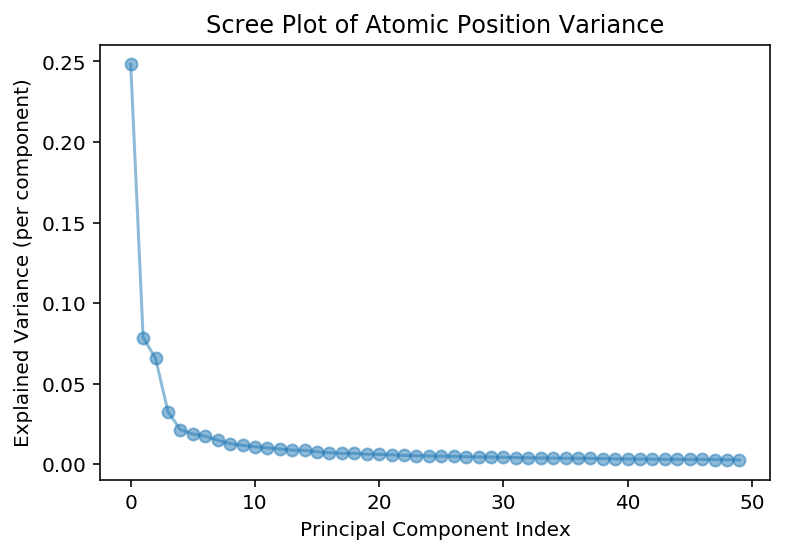

In [83]:
import matplotlib
from matplotlib import pyplot as plt

eigenvalues = data[1][0]
variance_explained = [eigenvalues[i] / sum(eigenvalues) for i in range(len(eigenvalues))]

print("There are {} eigenvalues total".format(len(eigenvalues)))

plt.plot([x for x in range(50)], variance_explained[0:50], marker='o', alpha=0.5)
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance (per component)")
plt.title("Scree Plot of Atomic Position Variance")


Analyzing the Scree plot, 5 principal components would be the most appropriate measure. 

Unfortunately we can only visualize 2, but let's cluster to 5 anyways.

In [84]:
print("{:.5f} of the variance is explained by 2 principal components".format(
    sum(variance_explained[0:2])))
print("{:.5f} of the variance is explained by 5 principal components".format(
    sum(variance_explained[0:5])))

0.32669 of the variance is explained by 2 principal components
0.44640 of the variance is explained by 5 principal components


Now, let's visualize how the trajectory 'wanders' over the first two principal components over the 2ns of trajectory.

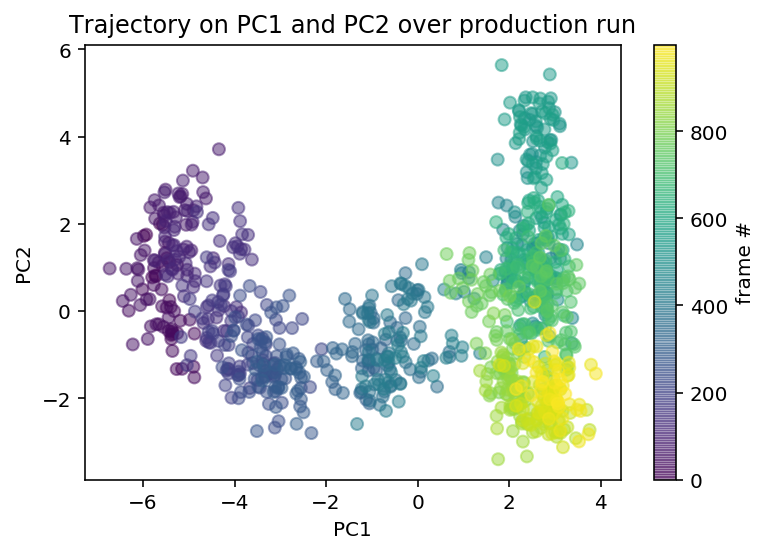

In [86]:
import matplotlib

projection_data = data[0]
from matplotlib import pyplot as plt

plt.scatter(projection_data[0], projection_data[1], marker='o', c=range(traj.n_frames), alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Trajectory on PC1 and PC2 over production run')
cbar = plt.colorbar()
cbar.set_label('frame #')    

We can solidly say that the simulation definitely 'wanders' over the course of the 2ns of dynamics. Now, let's cluster the frames within the trajectory on the first 5 principal components in order to obtain some typical values for each cluster which we can then use in our UMBRELLA sampling steps.

In [ ]:
import pandas as pd
import sklearn
import seaborn
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist, pdist


df = pd.DataFrame(data={'PC1': projection_data[0],
                        'PC2': projection_data[1],
                        'PC3': projection_data[2],
                        'PC4': projection_data[3],
                        'PC5': projection_data[4],
                         })

distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions, marker='o')
plt.ylabel("Distortion")
plt.xlabel("k")
plt.grid(True)
plt.title('Elbow curve')
